In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from numpy.lib.stride_tricks import sliding_window_view
import torch.nn.functional as F
from models.last_layer_models import LLI, train_last_layer_det, get_post_pred_dens, LastLayerVIClosedForm

from models.mc_dropout import MCDropoutNet
from models.bnn import BNN, train_bnn
from models.gibbs_sampler import gibbs_sampler, get_pred_post_dist, get_prediction_interval_coverage
from models.vi import  run_last_layer_vi_closed_form
from tqdm import tqdm
from utils.data_utils import create_synthetic_train_data, f

from utils.coverage import get_coverage_gaussian, get_coverage_y_hats

np.random.seed(100)

Text(0.5, 1.0, 'Training/Validation split')

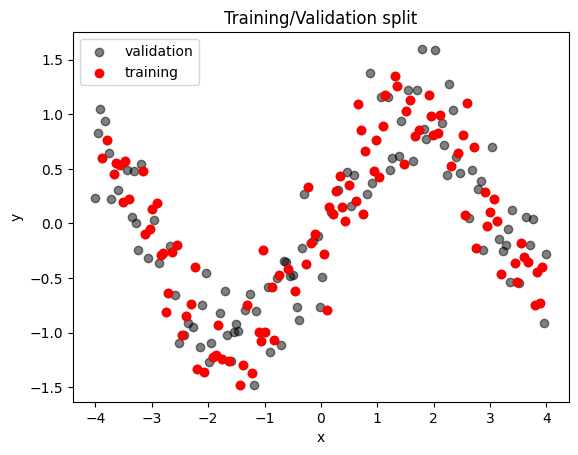

In [3]:
sigma_eps = 0.3
xs, ys, xs_train, ys_train, xs_val, ys_val = create_synthetic_train_data(xs_range = [-4,4], num_points = 200,  sigma_eps = sigma_eps)

# visualize train/val split
fig, axs = plt.subplots(1,1)
axs.scatter(xs, ys, c = 'black', label = 'validation', alpha =.5)
axs.scatter(xs_train, ys_train, c = 'red', label = 'training', alpha = 1)
axs.legend()
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title("Training/Validation split")

In [4]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
batch_size = 5
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=batch_size)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=batch_size)

In [5]:
# all models have 4 layers with 100, 100, 5 and 1 neuron(s), respectively.
model_dims = [1, 100, 100, 100, 50, 1]
num_epochs = 100
lli_net = LLI(model_dims)
sigma_0 = 0.3

100%|██████████| 100/100 [00:00<00:00, 163.04it/s]


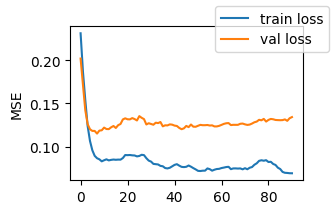

In [6]:
# train deep feature projector psi
lli_net, losses_train, losses_val = train_last_layer_det(model = lli_net, 
                                                         dataloader_train = dataloader_train,
                                                         dataloader_val = dataloader_val, 
                                                         num_epochs = num_epochs)

# plot losses
fig, axs = plt.subplots(1,1, figsize = (3,2))
axs.plot(sliding_window_view(np.array(losses_train), 10).mean(axis=1), label = 'train loss')
axs.plot(sliding_window_view(np.array(losses_val), 10).mean(axis=1), label = 'val loss')
axs.set_ylabel('MSE')
fig.legend()

In [7]:
import math 

T = 3000
a = .1
b = 1
gamma = math.log(100)/math.log(T+1)
sigma_eps = 0.3
sigma_eps_sq = sigma_eps**2

with torch.no_grad():
    Psi = lli_net.get_ll_embedd(xs_train)

In [8]:
w  = torch.ones(Psi.shape[1])*0.01
train_datas = []
epsilon_t = 0.1
N = len(dataloader_train.dataset)
warm_up = 2000
samples = []
for t in tqdm(range(T)):
    for batch_idx, train_data in enumerate(dataloader_train):

        xs_batch, ys_batch = train_data

        with torch.no_grad():
            Psi_batch = lli_net.get_ll_embedd(xs_batch)

        ys_pred = (Psi_batch @ w).unsqueeze(-1)

        # log prior + log likelihood + noise
        # l2 norma for Gaussian log prior
        d_log_prior = - w
        
        # gradient of log-likelihood
        residual = ys_batch - ys_pred
        d_log_likelihood = (Psi_batch.T @ residual)/sigma_eps_sq
        d_log_likelihood *= 1 / batch_size

        # full gradient
        d_full = d_log_likelihood + d_log_prior.reshape(-1,1)
        
        # noise for sampling
        eta = (torch.randn_like(w)* math.sqrt(epsilon_t)).reshape(-1,1)

        # update last-layer weights w_t
        w += (0.5*epsilon_t*d_full+ eta).squeeze()

        # update learning rate
        epsilon_t = a*(b + t)**(-gamma)

        if t > warm_up:
            samples.append(w.clone())

100%|██████████| 3000/3000 [00:03<00:00, 825.38it/s]


In [9]:
with torch.no_grad():
        Psi_val = lli_net.get_ll_embedd(xs_val)

thin = 5
pred_mus = []
for w_sample in samples[::thin]:
    pred_mu = Psi_val @ w_sample
    pred_mus.append(pred_mu.unsqueeze(-1))

pred_mus = torch.cat(pred_mus, dim = 1)
pred_mu = pred_mus.mean(dim = 1)

pred_sigma = torch.sqrt(pred_mus.var(dim = 1) + sigma_eps_sq)

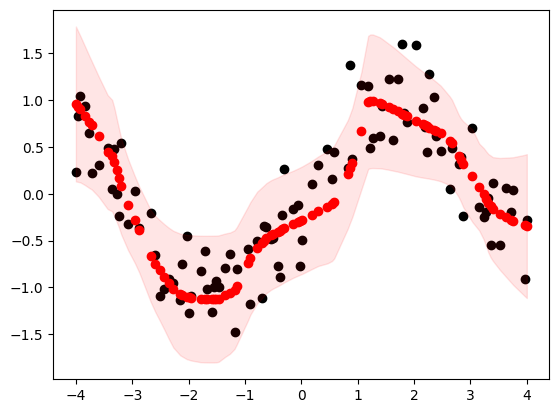

In [10]:
plt.scatter(xs_val, ys_val, color = 'black')
plt.scatter(xs_val, pred_mu, color = 'red')
plt.fill_between(xs_val.squeeze(), pred_mu - pred_sigma, pred_mu + pred_sigma, color = 'red', alpha = 0.1)

In [11]:
CI_levels = np.linspace(0.001, 0.99, 10)
coverage_sg_mcmc = get_coverage_gaussian(pred_mean = pred_mu.detach().numpy(), 
                                    pred_std = pred_sigma.detach().numpy(), 
                                    y_true = ys_val.detach().numpy().squeeze(), 
                                    levels=CI_levels)

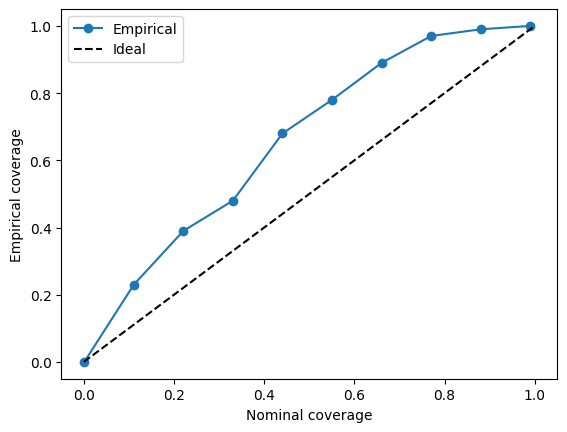

In [12]:
plt.plot(CI_levels, coverage_sg_mcmc, 'o-', label="Empirical")
plt.plot([0,1], [0,1], 'k--', label="Ideal")
plt.xlabel("Nominal coverage")
plt.ylabel("Empirical coverage")
plt.legend()
plt.show()

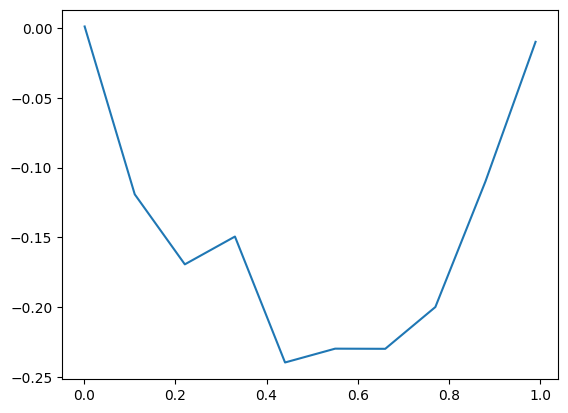

In [13]:
plt.plot(CI_levels, CI_levels - coverage_sg_mcmc)

In [14]:
from models.sg_mcmc import train_sg_mcmc_gauss, predict_sg_mcmc_gauss

In [18]:

w_samples, epsilon_ts =  train_sg_mcmc_gauss(Psi = Psi, 
                    lli_net = lli_net, 
                    dataloader_train = dataloader_train, 
                    batch_size = batch_size, 
                    sigma_eps_sq = sigma_eps_sq, 
                    a = a,
                    b = b, 
                    gamma = gamma,
                    T = T,
                    warm_up = warm_up)


100%|██████████| 3000/3000 [00:03<00:00, 800.84it/s]


TypeError: sum(): argument 'input' (position 1) must be Tensor, not list

In [19]:
pred_mu, pred_std = predict_sg_mcmc_gauss(lli_net = lli_net, 
                        xs_val = xs_val, 
                        w_sample = w_samples, 
                        sigma_eps = sigma_eps,
                        epsilon_ts = torch.tensor(epsilon_ts))

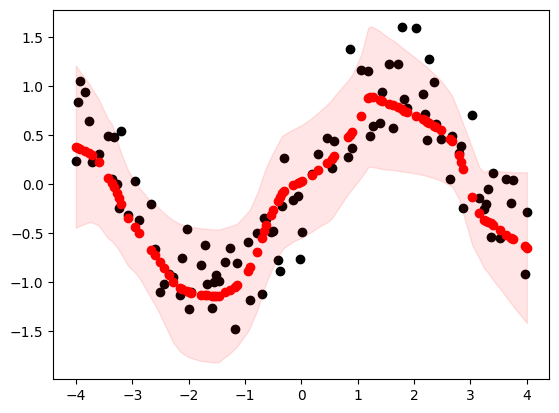

In [20]:
plt.scatter(xs_val, ys_val, color = 'black')
plt.scatter(xs_val, pred_mu, color = 'red')
plt.fill_between(xs_val.squeeze(), pred_mu - pred_sigma, pred_mu + pred_sigma, color = 'red', alpha = 0.1)

In [21]:
CI_levels = np.linspace(0.001, 0.99, 10)
coverage_sg_mcmc = get_coverage_gaussian(pred_mean = pred_mu.detach().numpy(), 
                                    pred_std = pred_std.detach().numpy(), 
                                    y_true = ys_val.detach().numpy().squeeze(), 
                                    levels=CI_levels)

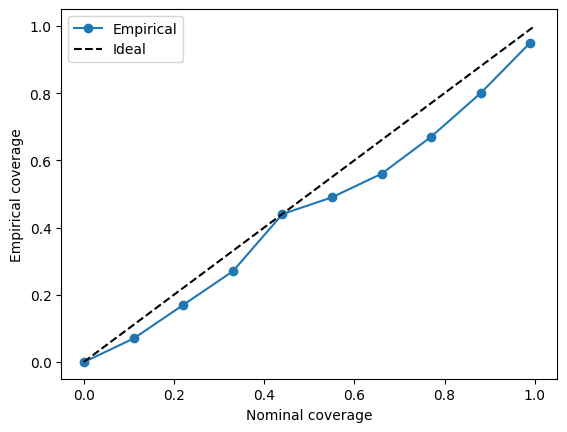

In [22]:
plt.plot(CI_levels, coverage_sg_mcmc, 'o-', label="Empirical")
plt.plot([0,1], [0,1], 'k--', label="Ideal")
plt.xlabel("Nominal coverage")
plt.ylabel("Empirical coverage")
plt.legend()
plt.show()

# old

In [2]:
# 1. Generate nonlinear synthetic data
torch.manual_seed(0)
N = 100
X = torch.linspace(-2, 2, N).unsqueeze(1)
y = torch.sin(3 * X) + 0.3 * torch.randn_like(X)

# 2. Simple MLP model
class BayesianMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
# 3. SGLD training function
a = 1e-2       # initial scale for step size
b = 100        # offset for schedule
gamma = 0.55   # decay rate (0.5 < gamma <= 1)
burn_in = 1000 # number of iterations to discard
num_samples = 5000 # total SGLD steps (including burn-in)

def sgld_lr(t):
    return a / ((b + t) ** gamma)

def sgld_train(model, X, y, lr=1e-2, noise_std=1e-2, n_steps=5000, burn_in=1000):
    samples = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    t = 0

    for step in range(n_steps):
        t += 1
        lr = sgld_lr(t)
        model.train()
        optimizer.zero_grad()
        preds = model(X)
        loss = ((preds - y)**2).mean()
        loss.backward()

        with torch.no_grad():
            for p in model.parameters():
                if p.grad is not None:
                    noise = torch.randn_like(p) * (2 * lr * noise_std)**0.5
                    p.add_(-lr * p.grad + noise)

        if step >= burn_in and step % 10 == 0:
            samples.append({k: v.detach().clone() for k, v in model.state_dict().items()})

    return samples


In [4]:

# 4. Train with SGLD
model = BayesianMLP()
samples = sgld_train(model, X, y)

# 5. Predictive posterior
X_test = torch.linspace(-4, 4, 200).unsqueeze(1)
predictions = []

for s in samples[::20]:  # Thin samples for plotting
    model.load_state_dict(s)
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        predictions.append(y_pred)

predictions = torch.stack(predictions)

In [ ]:
# 6. Plot
mean_pred = predictions.mean(0)
std_pred = predictions.std(0)

plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y.numpy(), color='black', label="Data", alpha=0.6)
plt.plot(X_test.numpy(), mean_pred.numpy(), label="Mean prediction", color="blue")
plt.fill_between(
    X_test.squeeze().numpy(),
    (mean_pred - 2 * std_pred).numpy(),
    (mean_pred + 2 * std_pred).numpy(),
    alpha=0.3, color="blue", label="±2 std"
)
plt.title("Bayesian Neural Network via SGLD")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import math
import matplotlib.pyplot as plt

# ==== Config ====
a = 1e-2       # initial scale for step size
b = 100        # offset for schedule
gamma = 0.55   # decay rate (0.5 < gamma <= 1)
burn_in = 500  # discard these steps
num_samples = 3000  # total steps including burn-in

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Synthetic data ====
torch.manual_seed(0)
X = torch.linspace(-3, 3, 100).unsqueeze(1).to(device)
y_true = torch.sin(X) * 0.5
y = y_true + 0.1 * torch.randn_like(y_true)

dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# ==== Model ====
model = torch.nn.Sequential(
    torch.nn.Linear(1, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 1)
).to(device)

# ==== Step size schedule ====
def sgld_lr(t):
    return a / ((b + t) ** gamma)

# ==== Training ====
posterior_samples = []
t = 0

for epoch in range(3000):
    for batch_x, batch_y in loader:
        t += 1
        lr = sgld_lr(t)

        # Forward
        preds = model(batch_x)
        loss = torch.nn.functional.mse_loss(preds, batch_y)

        # Backward
        loss.backward()

        # SGLD update
        with torch.no_grad():
            for p in model.parameters():
                if p.grad is None:
                    continue
                noise = torch.randn_like(p.grad) * math.sqrt(2 * lr)
                p.add_(-lr, p.grad + noise)
                p.grad.zero_()

        # Store posterior samples
        if t > burn_in:
            # clone parameters so they are not overwritten
            posterior_samples.append([p.clone().detach().cpu() for p in model.parameters()])

        if t >= num_samples:
            break
    if t >= num_samples:
        break

# ==== Predictions from posterior ====
X_plot = torch.linspace(-3, 3, 200).unsqueeze(1).to(device)
predictions = []

for sample_params in posterior_samples:
    # load parameters into model
    for p, new_p in zip(model.parameters(), sample_params):
        p.data.copy_(new_p.to(device))
    with torch.no_grad():
        predictions.append(model(X_plot).cpu())

predictions = torch.stack(predictions)  # [num_samples, num_points, 1]
mean_pred = predictions.mean(0).squeeze()
std_pred = predictions.std(0).squeeze()

# ==== Plot ====
plt.figure(figsize=(8, 5))
plt.plot(X.cpu(), y_true.cpu(), 'g--', label="True function")
plt.scatter(X.cpu(), y.cpu(), s=15, label="Data", alpha=0.7)
plt.plot(X_plot.cpu(), mean_pred, 'b', label="Posterior mean")
plt.fill_between(X_plot.squeeze().cpu(),
                 mean_pred - 2*std_pred,
                 mean_pred + 2*std_pred,
                 color='blue', alpha=0.2, label="±2 std. dev.")
plt.legend()
plt.title("SGLD Bayesian Regression (Welling & Teh Schedule)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
